## 1. 데이터셋 구성하기

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

### 1.1 CIFAR-10 데이터셋 불러오기

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 3s 0us/step


(50000, 32, 32, 3)

### 1.2 이미지 정규화

In [3]:
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [4]:
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
train_x.shape

(50000, 32, 32, 3)

### 1.3 데이터 시각화

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


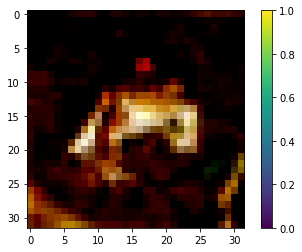

In [6]:
plt.imshow(train_x[0].reshape(32, 32, 3))
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

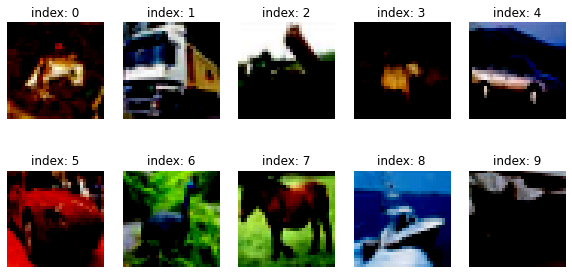

In [7]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i].reshape(32, 32, 3))
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

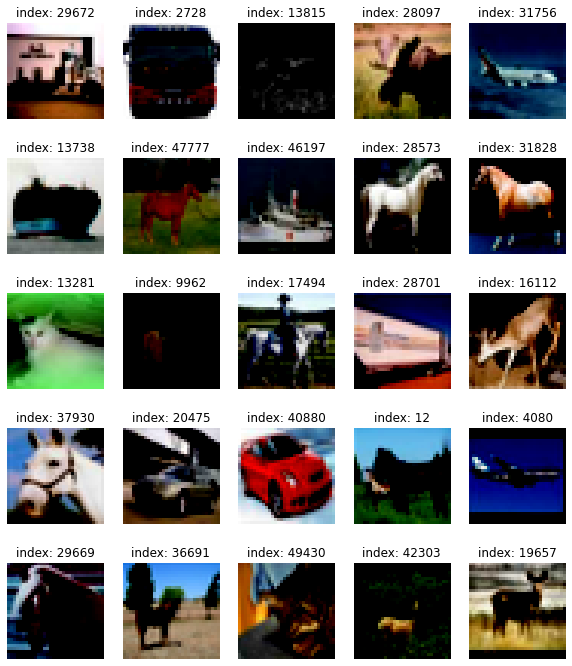

In [8]:
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow(train_x[random_index].reshape(32, 32, 3))
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

### 1.4 미니배치 데이터셋 구성

In [9]:
BUFFER_SIZE = 50000
BATCH_SIZE = 256

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 2. 생성자 모델 구현하기

### 2.1 생성자 모델 구현 함수

In [11]:
def make_generator_model():
    
    # Start
    model = tf.keras.Sequential()
    
    # First: Dense layer
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Second: Reshape layer
    model.add(layers.Reshape((4, 4, 256)))
    
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Sixth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(3, 3), padding='same', use_bias=False, \
                                     activation='tanh'))
    
    return model

In [12]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4096)              409600    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         524288    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 128)       2

### 2.2 랜덤 이미지 생성

In [13]:
noise = tf.random.normal([1, 100])

In [14]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

### 2.3 생성된 랜덤 이미지 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


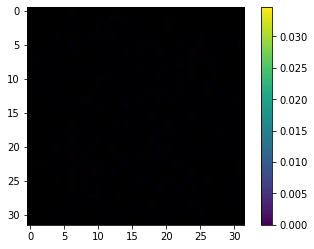

In [15]:
plt.imshow(generated_image[0, :, :, :])
plt.colorbar()
plt.show()

## 3. 판별자 모델 구현하기

### 3.1 판별자 모델 구현 함수

In [16]:
def make_discriminator_model():
    
    # Start
    model = tf.keras.Sequential()
    
    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    # Third: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    # Fourth: Conv2D Layer
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.3))
    
    # Fifth: Flatten Layer
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    
    # Sixth: Dense Layer
    model.add(layers.Dense(1))
    
    return model

In [17]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        1792      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)        

### 3.2 생성한 랜덤 이미지 확인

In [18]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00030441]], dtype=float32)>

## 4. 손실함수와 최적화 함수 구현하기

### 4.1 손실함수 구현

In [19]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [20]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [21]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### 4.2 정확도 계산 함수 구현

In [22]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

### 4.3 Optimizer 정의

In [23]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [24]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## 5. 훈련과정 상세 기능 구현하기

### 5.1 미니배치 훈련 과정을 처리하는 함수 구현

In [25]:
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

### 5.2 훈련 과정 동안 생성한 이미지 시각화 함수 구현

In [26]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i])
        plt.axis('off')
   
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

### 5.3 accuracy 히스토리 시각화 함수 구현

In [27]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 15    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['real_accuracy'])
    plt.plot(history['fake_accuracy']) 
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['real_accuracy', 'fake_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

### 5.4 checkpoint 모듈 설정

In [28]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 6. 학습 과정 진행하기

### 6.1 모델 학습 진행

In [29]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [30]:
save_every = 5
EPOCHS = 1000

# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

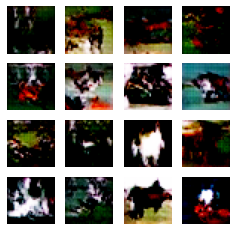

Time for training : 27807 sec


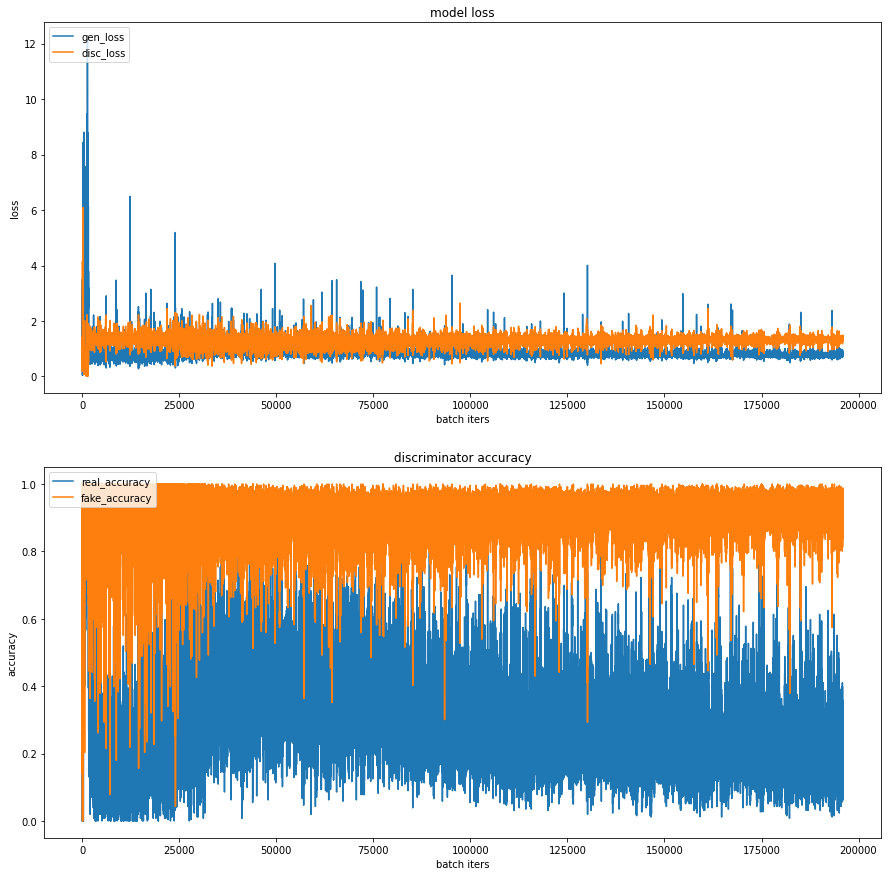

CPU times: user 7h 44min 42s, sys: 28min 27s, total: 8h 13min 10s
Wall time: 7h 43min 38s


In [31]:
%%time
train(train_dataset, EPOCHS, save_every)

### 6.2 학습 진행 과정 시각화

In [32]:
# 학습과정 시각화하기
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_6.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/cifar10/cifar10_6.gif

-rw-r--r-- 1 root root 5307693 Feb 14 09:49 /aiffel/aiffel/dcgan_newimage/cifar10/cifar10_6.gif


### 6.3 샘플 이미지, 그래프 이미지

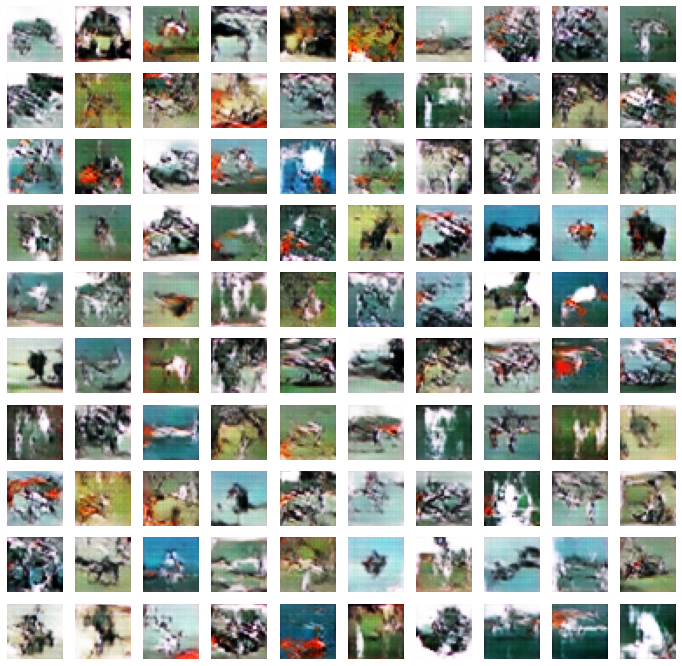

In [33]:
# checkpoint를 통해 모델 로드
checkpoint_dir = os.getenv('HOME')+'/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다.
plt.figure(figsize=(12, 12))

for i in range(100):
    plt.subplot(10, 10, i+1)
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)
    np_generated = generated_image.numpy()
    np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
    np_generated = np_generated.astype(int)
    plt.imshow(np_generated[0])
    plt.axis('off')
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

<br><br><br><br><br><br><br><br><br><br><br><br>
# 📕회고

## 과정

### 1. 층 추가, 드롭아웃,  stride 값, 커널 사이즈 변경하고 훈련 횟수를 늘림
다음 깃허브를 참고하여 코드를 수정했다.<br>
https://github.com/LilPark/AIFFEL_project/blob/main/Exploration_13/%5BE-13%5DDcganCifar10.ipynb<br>
↑박창근님의 깃허브<br>

해당 깃허브에서는 층 추가, 드롭아웃, stride 값, 커널 사이즈 변경한 상태였는데 이 상태 그대로 500회 훈련을 마쳤다.<br>
이미지는 결과도 괜찮고 그래프의 모양도 안정적이나, fake accuracy가 0.5로 향하고 있다고 하기에는 부족한 느낌이었다.<br>
그래서 추가적으로 다른 방법들을 시도해 보기로 결정했다.<br>

<img width="700" alt="이미지1" src="https://user-images.githubusercontent.com/96965899/153167306-0e0d49e8-e800-430c-b601-29e44f098c26.png">


<img width="700" alt="0 5 그래프" src="https://user-images.githubusercontent.com/96965899/153021170-2e01bba7-3411-466f-be78-00de8bdc8ec6.png">

### 2. 배치정규화를 인스턴스 norm으로 바꿔 훈련
1번의 조건을 유지한 상태로 배치정규화를 인스턴스 norm으로 바꿔 훈련했다. <br>
그러나 이미지 결과가 더 악화되었다.<br>

### 3.  활성화 함수를 adam에서 SGD 함수로 변경하여 1000회 훈련
1000회 돌린 결과치고 이미지 개선이 눈에 띄게 이뤄지지 않았고, 그래프 상태는 심각하게 악화되었다.<br>

<img width="700" alt="이미지3" src="https://user-images.githubusercontent.com/96965899/153166983-940bcf9b-99c2-4819-a971-52e78980443d.png">

<img width="700" alt="0 5 그래프 3" src="https://user-images.githubusercontent.com/96965899/153167377-5c489c43-8c2f-4f1b-8f6a-517ed784d16c.png">

**참고**<br>
* 하성민님의 도움

### 4. 배치사이즈를 256에서 128로 줄이고 500회 훈련
나의 경험과 동료들의 의견을 취합한 결과 훈련 횟수를 500회 이상으로 늘리는 것은 의미가 없다고 결론지었다.<br>
성능 개선이 있었던 동료들의 조언을 참고삼아 3번의 상태에서 배치사이즈를 256에서 128로 줄이고 훈련 횟수를 500회 시도했다.<br>
이미지 결과는 2번째 보다는 좋지만 첫번째 방법과 비슷한 정도이다. <br>
그래프는 첫번째가 더 좋았다.<br>
배치사이즈를 줄인 것이 효과가 있다고 말하기에 부족하다는 생각에 첫번째 상태로 돌아가 배치사이즈만 조절한 상태로 훈련하기로 결정했다.<br>

<img width="700" alt="EX10" src="https://user-images.githubusercontent.com/96965899/153318862-8b55f274-d43e-4901-99cf-9ed266745ae4.png">
<img width="700" alt="0 5그래프" src="https://user-images.githubusercontent.com/96965899/153318934-41affe6f-055a-4441-a348-d2db2454e295.png">

    
### 5. 1번에서 배치사이즈를 128로 줄임
1번과 큰 차이는 없었다.<br>
    
<img width="700" alt="이미지" src="https://user-images.githubusercontent.com/96965899/153360740-d0163caf-282a-4081-9b10-e3fcb48e8735.png">
<img width="700" alt="그래프" src="https://user-images.githubusercontent.com/96965899/153360801-9dc7568e-710a-4381-990a-c5a87b2f4e26.png">


### 6. 활성화함수를 ReLU로 바꿈
DCGAN 논문에서는 생성자의 활성화 함수를 LeakyReLU가 아니라 ReLU를 사용했음을 참고해 1번의 상태에서 활성화함수를 ReLu로 바꾸고 500회 훈련시켰다. <br>(이 과정에서 LeakyReLU와 달리 ReLU는 alpha값이 없음을 알게 되었다.)<br>
그런데 훈련 중간에 보니 아래와 같은 모습이어서 학습을 중단했다.<br>
    
<img width="350" alt="렐루로 수정한 뒤" src="https://user-images.githubusercontent.com/96965899/153392291-681772f8-e593-4e90-8d60-cd80d5fc776d.png">

**참고**<br>
* 박창근님의 도움
    
### 7. 이미지 크기를 32에서 48로 늘림
1번의 상태에서 이미지 크기만 변경했다.<br>
처음 이미지 크기를 64로 늘리는 시도를 했을 때, 에폭이 시작되는 지점에서 계속 커널이 죽어서 시도해 볼 수 없었다.<br>

#### 이 과정에서 생긴 오류와 해결법
처음에 reshape의 숫자만 변경했는데 에러메세지가 떴다.
train_x[0]의 크기가 32X32X3이라서 더 큰 크기로 변경하기 위해서는 데이터 자체가 작은 크기라 이미지라면 cv2.resize처럼 크기를 변경하는 함수를 호출해야 한다는 것을 알게 되었다.<br>
애초에 가지고 있는 데이터가 32X32X3=3072라서 64X64X3=12288개의 데이터로 표현할 수가 없기 때문에 오류가 난 것이다.<br>
동료와 퍼실님의 도움으로 리사이즈 함수를 만들고 그것에 맞춰 이미지 크기와 관련이 있는 숫자들을 고쳐주었다.<br>
또 하나의 오류는 훈련 시작 직전에 커널이 죽는 오류였는데 BUFFER_SIZE를 이미지 크기가 늘어난만큼 혹은 그 이상으로 감안하여 줄여서 해결했다.<br>

#### 결과
눈에 띄는 정도는 아니지만 이미지 개선이 일어났다.<br>
fake accuracy가 0.5를 명확히 향하고 있다고 할 수는 없지만 real accuracy가 올라갔다.
<img width="700" alt="이미지" src="https://user-images.githubusercontent.com/96965899/153518841-8e8574ad-dbe9-4b99-b178-99c0de5a4dc4.png">

<img width="700" alt="그래프" src="https://user-images.githubusercontent.com/96965899/153518882-ab21e1d1-eca1-499a-8d06-22c05902d129.png">

**참고**<br>
* 김지훈님의 도움

### 8. 5번/7번 각각의 상태에 배치사이즈를 512로 늘리고 learning rate를 넣음
5번과 7번 중에 어떤 것이 결과가 더 좋은지 확신할 수 없어서 두 가지로 나눠 훈련을 진행하기로 했다.<br>
배치사이즈를 얼만큼 늘릴지, learning rate를 어떻게 추가하는지 동료에게 조언을 구해 각각 500회 훈련시켰다.<br>

#### 5번에 적용한 결과
<img width="700" alt="이미지 8-1" src="https://user-images.githubusercontent.com/96965899/153705799-70ad2ed6-ead1-43cf-bf1e-955f68791b54.png">
<img width="700" alt="그래프 8-1" src="https://user-images.githubusercontent.com/96965899/153705816-2d9cfc54-6a20-49a6-a169-a4020c08b443.png">

확연한 이미지 개선이 있었다. 그러나 그래프에서 5번의 결과와 마찬가지로 앞쪽은 0.5를 향하는 구간이 있지만 뒤쪽으로 갈수록 그렇지 않았다.<br>
(검출정확도가 0퍼에 수렴한다는 것은 가짜로 만드는게 너무 뛰어나거나 검출력이 부족한 것)<br>

#### 7번에 적용한 결과
배치사이즈를 늘리자 훈련시작 직전 커널이 죽는 현상이 생겼다.<br>
7번에서 사용했던 버퍼 사이즈를 줄임으로써 해결했다.<br>
5번에 적용한 결과와 마찬가지로 이미지에서 큰 개선이 있었지만 그래프는 유의미한 결과를 얻지 못했다.<br>
<img width="700" alt="8-2이미지" src="https://user-images.githubusercontent.com/96965899/153705838-040156c1-bd7e-4f3a-92a0-5143cc91c0cc.png">
<img width="700" alt="8-2그래프" src="https://user-images.githubusercontent.com/96965899/153705847-72f10944-5924-4fe5-8cde-264ecdef8cd0.png">

**참고**<br>
* 김영철님의 도움

### 9. 1번에서 배치사이즈만 64로 줄여 500회 훈련
이미지와 그래프 모두 유의미한 결과를 얻지 못했다.
배치사이즈를 줄이는 것만으로는 별다른 효과를 얻지 못했다.
오히려 늘리는 쪽이 좋았던 것 같다.

<img width="700" alt="9번 이미지" src="https://user-images.githubusercontent.com/96965899/153736552-6c1d3376-c074-466e-83fe-aa737f597679.png">

<img width="700" alt="9번 그래프" src="https://user-images.githubusercontent.com/96965899/153736571-73f20a38-0601-44da-b798-39609794e607.png">

### 10. 1번의 상태에서 배치사이즈만 512로 늘려 500회 훈련
이미지에는 개선이 없었으나 그래프에는 많은 개선이 있었다.

<img width="700" alt="10번이미지" src="https://user-images.githubusercontent.com/96965899/153744106-823061fa-5472-4bb2-a9ac-71babce39be0.png">

<img width="700" alt="10번그래프" src="https://user-images.githubusercontent.com/96965899/153744110-c3835126-4bef-4297-9d57-0a376a005096.png">


### 11.  dropout 및 BatchNormalization layer 대량 제거, 배치사이즈 512, 500회 훈련
다음 깃허브를 참고하여 필자가 시도해 보려 했던 코드를 배치사이즈 512 상태에서 실행했다.<br>
https://github.com/LilPark/AIFFEL_project/blob/main/Exploration_13/%5BE-13%5DDcganCifar10.ipynb<br>


>모델 구조를 다시 바꿔서 돌리는 중이지만, 시간이 부족해서 결과에 첨부하지는 못했다. 현 시점에서 약 200epochs 이 진행되었고, 생성된 이미지를 확인했을 때, 현재 주피터 노트북에 있는 모든 결과들보다 훨씬 좋은 결과를 얻을 것이라고 예상된다. 해당 모델의 코드를 아래에 추가로 첨부하였다. 모델의 깊이는 비슷하지만, BatchNormalization layer를 더 제거하였고, dropout layer도 대부분 제거했다. 아마도 아래의 모델이 더 좋은 성능을 보일 것이라고 예측하는데, 그 이유는 dropout layer를 제거했기 때문이라고 판단한다. 물론, dropout이 없기때문에 overfitting의 가능성이 높지만, 모델이 더 많은 feature를 고려할 수 있고, 따라서 결과적으로 cifar10의 이미지와 유사한 이미지가 빨리 생성되는 것이라고 생각한다.<br> [박창근님 깃허브 회고중]


<img width="700" alt="11번 이미지" src="https://user-images.githubusercontent.com/96965899/153753564-8d49b4f0-4ebd-483d-9491-d675b2ed6b23.png">

<img width="700" alt="11번 그래프" src="https://user-images.githubusercontent.com/96965899/153753576-84656c6c-a8e7-496e-8937-fdd218fd6de8.png">

### 12. 1번에서 그래프 출력 순서를 바꾸고 1000회 훈련
10번 학습을 돌리는 중에 mode collapse에 대해 알게 되었다.
하지만 해결방법으로 제시된 것들을 구현하기에 능력 부족이어서 추후 이해하게 됐을 때 다시 시도해 보기로 결정했다.
1~11번까지 시도했던 것 중에 가장 좋았던 1번으로 다시 돌아가서 그래프를 fake accuracy가 앞으로 나오도록 수정해 한번 더 확인해 보기로 했다.
훈련횟수는 1000번으로 했다.

#### 결과
훈련횟수는 예상대로 500회 이상에서 큰 차이를 나타내지 않았다.


<img width="700" alt="12이미지" src="https://user-images.githubusercontent.com/96965899/153870230-1741aace-81cb-480f-97cd-30d62a4fb0a5.png">

<img width="700" alt="12그래프" src="https://user-images.githubusercontent.com/96965899/153870368-9f01fd63-4dac-4af7-b6fb-31b1d50efc29.png">


#### mode collapse
mode collapsing 해결방안 가운데 효과적인 것으로 알려진 방법은 다음과 같다.
모델이 전체 데이터 분포의 경계를 골고루 학습하게 하고, 그것을 계속 기억할 수 있도록 하는 것이 핵심이다.

* feature matching : 가짜 데이터와 실제 데이터 사이의 least square error를 목적함수에 추가
* mini-batch discrimination : 미니배치별로 가짜 데이터와 실제 데이터 사이의 거리 합의 차이를 목적함수에 추가
* historical averaging : 배치 단위로 파라메터를 업데이트하면 이전 학습은 잘 잊히게 되므로, 이전 학습 내용을 기억하는 방식으로 학습
* LSGAN, WGAN, F-GAN, EBGAN 등 손실함수를 바꿔서 이 문제를 해결

**참고**<br>
* 윤영준님의 도움<br>
* 신채은님의 도움<br>

* https://raon1123.blogspot.com/2019/10/gan-model-collapse.html<br>
* https://velog.io/@tobigs-gm1/basicofgan<br>
* https://ratsgo.github.io/generative%20model/2017/12/20/gan/<br>

<br><br>
## 13. 1번의 상태에서 learning rate값을 0.01 / 0.001 / 0.00001로 추가
12번이 실행되는 동안 플립시간에 Adam 의 learning rate, beta 값에 대해 알게 되었다.
13번과 14번에 각각을 시도하기로 했다

### learning rate 0.01
<img width="350" alt="러닝레이트0 01" src="https://user-images.githubusercontent.com/96965899/153979234-48411f2a-9437-4939-9c91-f606d0b4f4dd.png">
<br>
### learning rate 0.001
<img width="350" alt="러닝레이트0 001" src="https://user-images.githubusercontent.com/96965899/153979311-41bc6bf1-7656-4d9e-9369-d0609a7f9e14.png">
<br>
### learning rate 0.00001
<img width="700" alt="이미지 13" src="https://user-images.githubusercontent.com/96965899/154063017-e021649f-4b5f-41f5-b857-84ec50d5cb06.png">

<img width="700" alt="베타0 7 그래프" src="https://user-images.githubusercontent.com/96965899/154063088-62847f99-0b03-4d85-8297-1d15151bf4a8.png">


#### learning rate :
learning rate는 0.01로 설정 후 학습해보고 학습 결과가 발산하면 값을 줄이고 학습시간이 너무 오래 걸리면 큰 값으로 설정한다.
cost가 줄어들지 않고 발산해서 ovorshooting 일어난다.
최적화된 W값에서 멈추지 못하고 지나치게 된다.

**참고**
* 박민균님의 CS231n 발표자료<br>
* https://hiddenbeginner.github.io/deeplearning/2019/09/22/optimization_algorithms_in_deep_learning.html<br>

## 14. 1번의 상태에서 beta_1값을  0.5 / 0.7 / 0.9로 추가
셋 중에서는 0.5의 수치가 좋은 성능을 나타냈지만 아예 learning rate가 없는 쪽이 훨씬 나았다.

### beta_1 0.7

<img width="700" alt="베타0 7 이미지" src="https://user-images.githubusercontent.com/96965899/154063778-b492db3c-b4e2-4d8e-ba51-70649f879c0d.png">

<img width="700" alt="베타0 7 그래프" src="https://user-images.githubusercontent.com/96965899/154063841-7b820933-cc76-4209-8d0e-b688467214d2.png">


#### beta : 
베타가 클수록 최근 편향을 가장 많이 반영한다.
대부분의 경우 beta_1=0.9 , beta_2=0.999 값에서 성능이 좋다고 알려져 있다.


**참고**
https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=sohyunst&logNo=221587342856<br>

<br><br>
- - -
<br><br>
## GIF
14번의 시도 중에 다른 것들에 비해 성능의 개선을 나타냈다고 생각되는 12번의 시도를 캡쳐했다.

### 10 epoch
![10 epoch](https://user-images.githubusercontent.com/96965899/154063997-5829843d-688e-476f-9290-e348a9ae0d16.gif)

### 300 epoch
![300epoch](https://user-images.githubusercontent.com/96965899/154064300-3908a2dc-10f2-4331-8804-e19a263dfd74.gif)

### 600 epoch
![600epoch](https://user-images.githubusercontent.com/96965899/154064342-620b5984-c5d9-4a25-b74f-8e292d0f1558.gif)

### 900 epoch
![980epoch](https://user-images.githubusercontent.com/96965899/154064398-020d1bd8-0e78-484f-81c2-44d58ab7547f.gif)


## 성능 개선을 위해 시도한 방법들

* conv stride ✔ :결과 👍 **그래프↑**<br>
* 생성 모델에 없는 dropout 추가 ✔ 결과 👍 **그래프↑**<br>
dropout 및 BatchNormalization layer 대량 제거 ✔ :결과 <br>
* adam을 SGD함수로 교체 **✔ 결과 🤨 이미지↑, 그래프↓**<br> 
* 배치정규화 -> 인스턴스 norm ✔ 결과 👎 **이미지↓, 그래프↓**<br>
* 배치사이즈를 64로 줄인다 ✔ :결과 🤨 <br>
* 배치사이즈를 256, 512 로 늘린다.✔ :결과 🤨 **이미지↓, 그래프↑**<br>
* learning rate 0.0001 ✔ :결과 🤨 **이미지↑, 그래프↓**<br>
* learning rate 0.01
* beta_1 0.9
* DCGAN 논문에서는 생성자의 활성화 함수를 LeakyReLU가 아니라 ReLU로 바꾼다✔ :결과 👎 **이미지↓, 그래프↓**<br>
* 이미지크기를 32에서 64이상으로 늘린다 ✔ :결과  **이미지↑**👍<br>


